In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

In [6]:
# ===========================
# 1. DATA IMPORTING & CLEANING
# ===========================

# Load dataset
df = pd.read_csv("neo.csv")

# Display basic info and check for missing values
print(df.info())
print(df.isnull().sum())

# Handle Missing Values: Drop rows with missing values
df = df.dropna()

# Drop irrelevant columns
df = df.drop(columns=['name', 'orbiting_body'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20924 entries, 0 to 20923
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neo_id                  20924 non-null  int64  
 1   name                    20924 non-null  object 
 2   absolute_magnitude      20924 non-null  float64
 3   estimated_diameter_min  20924 non-null  float64
 4   estimated_diameter_max  20923 non-null  float64
 5   orbiting_body           20923 non-null  object 
 6   relative_velocity       20923 non-null  float64
 7   miss_distance           20923 non-null  float64
 8   is_hazardous            20923 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.4+ MB
None
neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    1
orbiting_body             1
relative_velocity         1
miss_distance             1
is_hazardous      

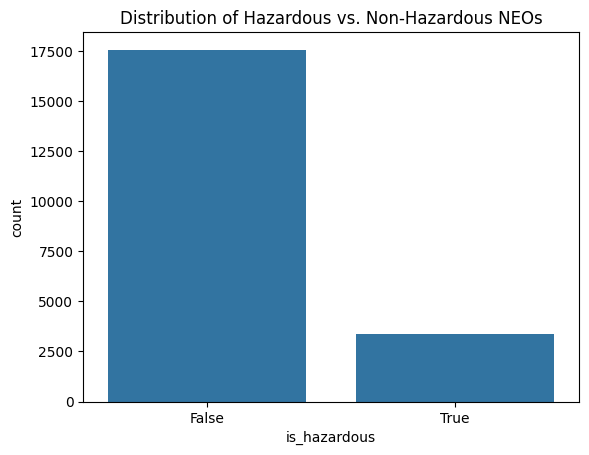

is_hazardous
False    83.941117
True     16.058883
Name: proportion, dtype: float64


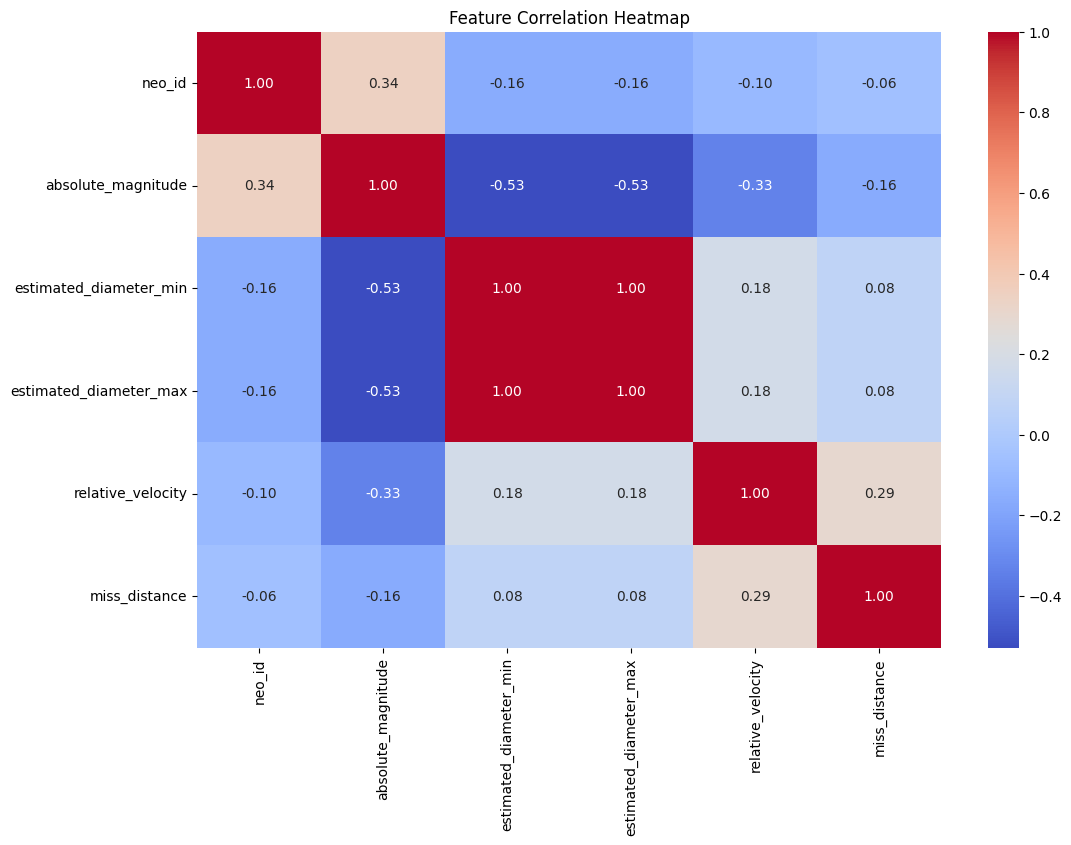

In [7]:
# ==============================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ==============================

# Visualizing target variable distribution
sns.countplot(x="is_hazardous", data=df)
plt.title("Distribution of Hazardous vs. Non-Hazardous NEOs")
plt.show()

# Display percentage of hazardous objects
hazardous_percentage = df["is_hazardous"].value_counts(normalize=True) * 100
print(hazardous_percentage)

# Correlation Heatmap (only numerical features)
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [8]:
# ==========================
# 3. DATA PREPROCESSING
# ==========================

# Handling Categorical Features
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols[categorical_cols != 'is_hazardous']

if len(categorical_cols) > 0:
    encoder = OneHotEncoder(drop="first")
    X_encoded = encoder.fit_transform(df[categorical_cols])
    encoded_columns = encoder.get_feature_names_out(categorical_cols)
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_columns)
    df = pd.concat([df, X_encoded_df], axis=1).drop(columns=categorical_cols)

# Separate features and target variable
X = df.drop(columns=["is_hazardous"])
y = df["is_hazardous"].astype(int)

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Handling Imbalanced Classes using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class balance after SMOTE
print(pd.Series(y_resampled).value_counts())


is_hazardous
0    17563
1    17563
Name: count, dtype: int64


              precision    recall  f1-score   support

           0       0.94      0.87      0.90      3537
           1       0.87      0.95      0.91      3489

    accuracy                           0.91      7026
   macro avg       0.91      0.91      0.91      7026
weighted avg       0.91      0.91      0.91      7026

AUC-ROC Score: 0.9717


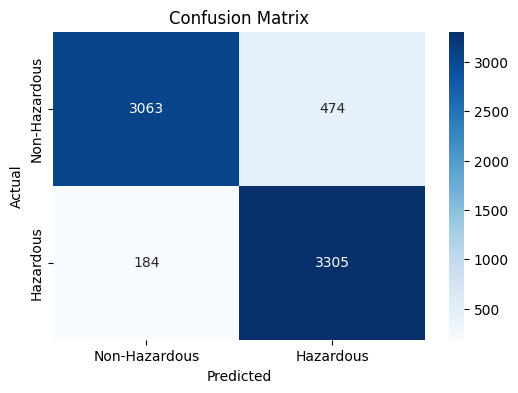

In [9]:
# ===========================
# 4. MODEL TRAINING & EVALUATION
# ===========================

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print(classification_report(y_test, y_pred))
roc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {roc_score:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Hazardous", "Hazardous"], yticklabels=["Non-Hazardous", "Hazardous"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
